# Business Analytics : TP 5

Idée du TP, c'set de finetuné le modèle pour lui donner le comportement et la manière de répondre qu'on souhaite. Egalement dans notre cas d'apprendre les différent objet que vend la plateforme.

Pour ça on a le dataset MG shop dial https://github.com/iai-group/MG-ShopDial qui reprend des conversation entre un client (potentiel) et un assistance ici humain.

L'idée ça va être d'entrainner le modèle à repliquer comment l'humain répond au client.



In [2]:
import pandas as pd
from transformers import AutoModelForCausalLM, AutoTokenizer, LlamaForCausalLM, pipeline
import torch
from tqdm import tqdm
import random

#entraintement
from peft import LoraConfig, get_peft_model
from transformers import TrainingArguments, Trainer,DataCollatorForLanguageModeling
from transformers import EarlyStoppingCallback

#métriques
import math
import numpy as np
import evaluate

### Chargement des données

Voit qu'on a 64 conversation (ce qui est peu pour un vrai entrainement) pour 64 produit différents.

On voit aussi qu'ils ont de nom un peu foclorique comme wizard et Client qu'on va renomer en agent et client étant donné que la pattern des données est proche du template chat format utilisé dans la plus part des LLM. Remarque aussi qu'il y a plusieurs message d'affilés de la même personne qui n'est pas très courrant pour un ChatBot donc nous allons fusioner ces différents messages pour avoir toujours user, agent, user, .... (ou inversement).

Les metadata correspond au context donné à l'humain pour aider le client à l'autre bout + les taches qu'il doit faire. Ils pourrait être utile pour l'entrainement.

In [3]:
df = pd.read_json('MGShopDial.json')

#va prendre que le text et verra plus tard si utilise metadata. mais comme demande pas mal traitement pour récuprer va commencer par se simplifier la tache.
df['utterances'] = df['utterances'].apply(lambda x: [{'role': u['participant'], 'content': u['utterance']} for u in x])  #supprimer tout ce qui a autour veut garder que le texte car va entrainner à prédire la suite et je pense pas qu'on aura besoin de tout le contexte


print(len(df['utterances']))

# va regouper les utterances des memes participants l'un à la suite de l'autre
all_utterances = []
for utterance_list in df['utterances']:
    # renome les rôle qui ne sont pas avec de nom standard
    for utterance in utterance_list:
        if utterance['role'].lower().strip() == 'wizard':
            utterance['role'] = 'assistant'
        elif utterance['role'].lower().strip() == 'client':
            utterance['role'] = 'user'
    
    # regroupe les utterances des memes participants l'un à la suite de l'autre
    merged_utterances = []
    previous_utterance = None
    for utterance in utterance_list:
        if previous_utterance and previous_utterance['role'] == utterance['role']:
            previous_utterance['content'] += ' ' + utterance['content']
        else:
            merged_utterances.append(utterance)
            previous_utterance = utterance
    utterance_list = merged_utterances #remet ou été avant


print(df['utterances'][0])  #affiche le premier element pour voir a quoi ca ressemble


64
[{'role': 'assistant', 'content': 'Hello, how I can help?'}, {'role': 'user', 'content': "Hello! I'm looking for some book "}, {'role': 'assistant', 'content': 'Any genre or author in particular?'}, {'role': 'user', 'content': 'either romance or classical literature, probably a combination?'}, {'role': 'assistant', 'content': 'Ok give me a moment to find some suggestions I only have romance and contemporary available. Will that be ok for you ?'}, {'role': 'assistant', 'content': 'I only have romance and contemporary available. Will that be ok for you ?'}, {'role': 'user', 'content': "what's the titles? "}, {'role': 'assistant', 'content': 'I have Regretting You by Colleen Hoover and People We Meet on Vacation by Emily Henry The first one is a bit shorter'}, {'role': 'assistant', 'content': 'The first one is a bit shorter'}, {'role': 'user', 'content': "is Regretting by you based on a family drama? i think i've heard of it "}, {'role': 'user', 'content': "i think i've heard of it "},

### Tokenization
Pour préparer l'entrainnement, il faut commencer par tokenizer tout le dataset. Contrairement au TP4, je ne vais pas me tracasser de faire du padding et je vais utilise un datacollector pour faire ça dans le training. 

Cepedant, il faudra continuer à corrêctement définir les lable et mettre -100 sur la question du client et les id des token sur la réponse de l'agent.

Mais pour tokenizer faut au moins charger le tokenizer donc charge tout le modèle ainsi déjà fait pour la suite

In [4]:
model_name = "./data/models/Llama-3.2-3B-Instruct"
# model_name = "./best_model_TP5" #pour le charger faut avoir le modèle LLama-3.2-3B-Instruct dans ./data/models car se base dessus

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

# model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto", torch_dtype="auto")
model = LlamaForCausalLM.from_pretrained(
    model_name,
    dtype=torch.float16,
    device_map="auto",
    load_in_8bit=False,
    load_in_4bit=True,
)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
max_length = 512 #définit longueur max des sequences si plus grand que ça tronque

def tokenize_element(element):
    rendered = tokenizer.apply_chat_template(element, tokenize=False, add_generation_prompt=False) #applique chat template pour mettre agent et user

    # print(rendered)  #voir a quoi ressemble le texte après application du template

    enc = tokenizer(rendered, 
                    return_tensors="pt", 
                    add_special_tokens=False, 
                    truncation=True, 
                    max_length=max_length,
                    return_offsets_mapping=True, #permet de récupérer pour chaque token la position dans le texte original
                    padding="max_length" #osef utilise datacollector et pas besoin de se faire chier la-dessus
                    )
    
    offset = enc['offset_mapping'][0]

    input_ids = enc["input_ids"][0]

    # decoded_text = tokenizer.decode(input_ids, skip_special_tokens=False)
    # print("Decoded text:", decoded_text)

    attention_mask = enc["attention_mask"][0]

    # print(input_ids)


    # va définir label à -100 quand client qui parle
    labels = input_ids.clone()

    labels[:] = -100  #par défaut tout à -100
    
    cursor = 0


    for msg in element: #pour chaque message
        content = msg["content"]  #prend le contenu

        start = rendered.find(content, cursor) #prend début et fin du renderd
        end = start + len(content) #ajoute longuer

        if msg["role"] == "assistant":
            for i, (s, e) in enumerate(offset): #enumre tous les offset pour voir celui qui se trouve entre et définir l'id du token pour le label
                if s >= start and e <= end:
                    labels[i] = input_ids[i]
                    # print("current token for label:", tokenizer.decode([labels[i]], skip_special_tokens=False))
                if s > end:
                    break #cut quand dépasse la fin
        cursor = end  #met à jour le curseur pour la prochaine recherche



    # check si pas d'erreur et doit avoir tout du text qui fait du ses  
    # decoded_labels = []
    # for i, label in enumerate(labels):
    #     if label != -100:
    #         decoded_labels.append(tokenizer.decode([label], skip_special_tokens=False))
    # print("Decoded labels:", decoded_labels)


    # mets la sortie comme demande pour après utiliser à l'entrainement
    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }



# tokenized_utterances = [tokenize_element(e) for e in tqdm(df['utterances'])]
tokenized_utterances = df['utterances'].apply(lambda x: tokenize_element(x)).tolist() #si veut le faire propre mais fait la même chose que juste en dessous

Cette étape est assez compliqué étant donné qu'il faut savoir retrouver chaque token d'où est-ce qu'il viens. On peut pas retokenizer à chaque fois sinon il ajoute un text à la con qui dit "knowledge cut off ....." disant que après une certaine date de ne connait plus rien. Sans fait attention perd l'ordre de token et l'entrainement ne sert plus à rien

Pour ensuite tester le modèle, on va créer un dataset de test, train et validation.

In [5]:
random.seed(42) #fix seed pour reproductibilité 
indices = random.sample(range(len(tokenized_utterances)), len(tokenized_utterances)) # génère des indices aléatoires
tokenized_utterances = [tokenized_utterances[i] for i in indices] # réorganise les données selon les indices aléatoires

normal_dialog = [df['utterances'][i] for i in indices] #garde aussi le dialog normal pour test plus tard

train_size = int(0.8 * len(tokenized_utterances)) #prend 80% pour train
train_dataset = tokenized_utterances[:train_size]
normal_dialog = normal_dialog[train_size:]

remaining = tokenized_utterances[train_size:]
val_size = int(0.5 * len(remaining)) #prend 10% pour val et 10% pour test
val_dataset = remaining[:val_size]
test_dataset = remaining[val_size:]
test_dialog = normal_dialog[val_size:]

### lancer le train

In [ ]:
# utilise un autre pour language modelling car plus adapté et continue à faire la même chose pour le batching comme pas voulu faire le padding moi même
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False
)

# configuration lora pour ajouter de chose
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "v_proj"],
    task_type="CAUSAL_LM",
)

#applique configuration lora
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()   # Doit montrer ~5M param entraînables

#trainer
training_args = TrainingArguments(
    output_dir="./llama_lora_tp5",
    per_device_train_batch_size=1, #nombre de batch par GPU
    gradient_accumulation_steps=16, #combien de step fait avant de faire un backward donc 1*16 voit 16 element
    learning_rate=2e-4, #pour LORA entre 1e-4 et 3e-4 marche bien souvent
    num_train_epochs=15, #nombre epoch
    per_device_eval_batch_size=1, #pour quand eval, quel batch size
    eval_strategy="epoch",         # definit quand on fait l'eval
    save_strategy="epoch",               # défini quand on fait checkpoint
    load_best_model_at_end=False,         # si recharger le meilleur modèle à la fin ce que j'ai remarqué était mauvais
    metric_for_best_model="eval_loss",   # métrique pour trouver le meilleur modèle
    greater_is_better=False,             # pour dire si max ou min
    logging_steps=10,
    fp16=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]  
)

trainer.train()

model.save_pretrained("./best_model_TP5")
tokenizer.save_pretrained("./best_model_TP5")

trainable params: 2,293,760 || all params: 3,215,043,584 || trainable%: 0.0713


Using EarlyStoppingCallback without load_best_model_at_end=True. Once training is finished, the best model will not be loaded automatically.


Epoch,Training Loss,Validation Loss
1,No log,3.066291
2,No log,2.457672
3,2.724800,2.278682
4,2.724800,2.175820
5,1.979800,2.107924
6,1.979800,2.051337
7,1.979800,1.998980
8,1.793600,1.950880
9,1.793600,1.921722
10,1.706000,1.901017


('./best_model_TP5/tokenizer_config.json',
 './best_model_TP5/special_tokens_map.json',
 './best_model_TP5/chat_template.jinja',
 './best_model_TP5/tokenizer.json')

## Evaluation du modèle

Pour évaluer le modèle, on peut utiliser plusieurs métriques :
- perpexlité
- BLEU
- ROUGE
- BLEURT
- ...

Ici je vais testé ces différents métriques. Pour ça je vais utilisé le dataset de test.

### Perpelxité
C'est une métrique stadard qui mesure l'incertitude du modèle.

Mathématiquement, il peut être définit comme étant :
$$\mathit{PP}(p) = \prod_x p(x)^{-p(x)} = b^{-\sum_x p(x)\log_b p(x)}$$

Elle correspond aussi à $e^{\text{loss cross entropy moyenne}}$.

In [7]:
model.eval() #mets le modèle en mode évaluation change comportement de certaines couches comme dropout ou batchnorm 
eval_results = trainer.evaluate(eval_dataset=test_dataset)

perplexity = math.exp(eval_results["eval_loss"])
print("Perplexity:", perplexity)

Perplexity: 5.110552311000396


### BLEU (Bilingual Evaluation Understudy)
Idée de bleu c'est d'avoir un algo qui va voir à quel point proche de ce qu'un humain à écrit pour ça utilise. Pour ça, se base sur légère modification d'un N-gram.

C'est un système qui va regarder par substring et lui va regarder combien de substring de la référence apparait dans ce qui a été généré.

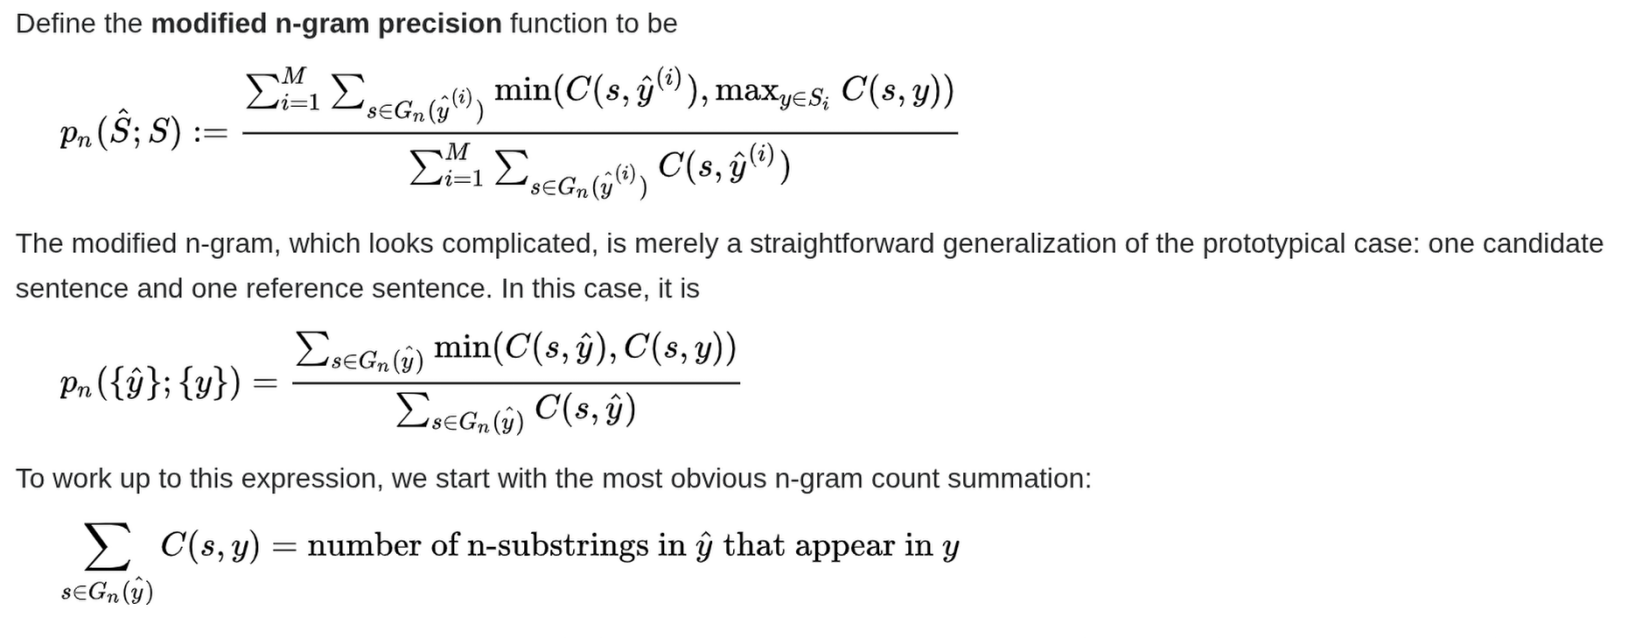

pour se faire, utilise le dataset, utiliser ce qui n'est pas caché pour prédire pour après utilisé l'algo BLUE pour le mesurer. Remarque si donne juste tout va prévoir 1 message en plus de tout mais nous veut prédire tout message donc faut rejouer pas mal de fois la conversation au complet pout avoir un message en plus à chaque fois et comparer ensuite ce dernier message à celui qui était attendu.

In [7]:
gen_inputs = []
gen_references = []

for dialog in test_dialog: #pour chaque dialog
    for i, msg in enumerate(dialog): #passe sur chaque message
        if i == 0:
            continue  # saute le premier message car pas de contexte avant
        if msg["role"] == "assistant":
            context = dialog[:i]        # prend tous les messages avant
            target = msg["content"]     # ce qu'on veut avoir ce les message actuel

            rendered = tokenizer.apply_chat_template( 
                context,
                tokenize=True,
                add_generation_prompt=True, #pour avoir à la fin le début quand le modèle doit générer ce qui est utile dans notre cas
                truncation=True, #coupe si trop long mais c'est longuer absurde d'a
                max_length=1512, #un peu plus grand que max length pour être sûr de pas couper le prompt osef de mémoire vidéo devrait passé ici comme modèle est entrainé
                return_tensors="pt"
            )

            gen_inputs.append({
                "input_ids": rendered[0],
                "attention_mask": torch.ones_like(rendered[0]),
            }) #mets tout dans gen_input qu'utilisera après pour

            gen_references.append(target)



model.eval() #mets en mode 
predictions = []

#pour chaque élément dans le dataset test

for example in tqdm(gen_inputs):
    input_ids = example["input_ids"].unsqueeze(0).to(model.device) #prend input et mets tout sur le gpu
    attention_mask = example["attention_mask"].unsqueeze(0).to(model.device)

    with torch.no_grad(): #génère une sorite
        generated_ids = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=128,
            do_sample=False  # le mets en greedy pour evaluation ce qui est le meilleur car sinon pourrait prendre des tournure de phrase différente mais correcte qu'on arrivera pas à dire qu'est correcte par un N-gram
        )

    # Decode pour avoir en text
    pred_text = tokenizer.decode(
        generated_ids[0][input_ids.shape[1]:],
        skip_special_tokens=True
    )

    predictions.append(pred_text)

bleu = evaluate.load("bleu") #load l'algo

bleu_score = bleu.compute( #compute
    predictions=predictions,
    references=[[ref] for ref in gen_references]  # BLEU expects list of references
)


print(bleu_score)

  0%|          | 0/101 [00:00<?, ?it/s]The following generation flags are not valid and may be ignored: ['temperature', 'top_p']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.
100%|██████████| 101/101 [09:03<00:00,  5.38s/it]


{'bleu': 0.016577576699383468, 'precisions': [0.06439649359406609, 0.014323064681141298, 0.009774609015639375, 0.008376963350785341], 'brevity_penalty': 1.0, 'length_ratio': 5.50278293135436, 'translation_length': 8898, 'reference_length': 1617}


### Rouge (recall oriented understudy for gistring evaluation)

C'est aussi une métrique utilisé pour regarder à quel point un text un bon par rapport à une référence. Elle utilise également un N-gram mais contraitement à BLEU, ROUGE mesure le recall et pas la precision.

C'est aussi une famille de métrique et en existe pas mal de différent qui varien en fonction du N ou de ce que recherche genre la plus longue substring qui est identique entre la référence et ce qu'on a prédit.

Comme on a déjà généré le text, il suffit d'utilisé *evaluate.load("rouge")*

In [9]:
rouge = evaluate.load("rouge")

rouge_scores = rouge.compute(
    predictions=predictions,
    references=gen_references
)

print(rouge_scores)

{'rouge1': np.float64(0.12125994893146393), 'rouge2': np.float64(0.03627641518932436), 'rougeL': np.float64(0.09943143523956059), 'rougeLsum': np.float64(0.10537980268269045)}


### BLEURT

Idée c'est d'utiliser BERT qui va servir de juge pour dire à quel point bon. L'intérêt c'est que bien meilleur pour long paragraphe, meilleur pour conversation ...


Passe toujours par evaluate.

Utilise un modèle supplémentaire et ça sera pas utilisable sur l'environnement je pense. Demande également pas mal de ram donc doit le forcer sur le CPU.

En plus à besoin de git donc peut même pas installer les library sur l'environnement du prof.

In [10]:
bleurt = evaluate.load("bleurt", "bleurt-base-128", device="cpu") #force en CPU car sinon jamais assez de VRAM

bleurt_scores = bleurt.compute(
    predictions=predictions,
    references=gen_references
)

print(bleurt_scores) #pas d'intéret car fait par exemple donc fait moyenne pour simplifier

mean_bleurt = np.mean(bleurt_scores["scores"])
print("Mean BLEURT:", mean_bleurt)

INFO:tensorflow:Reading checkpoint /home/cyril/.cache/huggingface/metrics/bleurt/bleurt-base-128/downloads/extracted/c4f84253f5994635cb8a739299d59e1132bb5a41568643899ae93a83ef7439a1/bleurt-base-128.


INFO:tensorflow:Reading checkpoint /home/cyril/.cache/huggingface/metrics/bleurt/bleurt-base-128/downloads/extracted/c4f84253f5994635cb8a739299d59e1132bb5a41568643899ae93a83ef7439a1/bleurt-base-128.


INFO:tensorflow:Config file found, reading.


INFO:tensorflow:Config file found, reading.


INFO:tensorflow:Will load checkpoint bert_custom


INFO:tensorflow:Will load checkpoint bert_custom


INFO:tensorflow:Loads full paths and checks that files exists.


INFO:tensorflow:Loads full paths and checks that files exists.


INFO:tensorflow:... name:bert_custom


INFO:tensorflow:... name:bert_custom


INFO:tensorflow:... vocab_file:vocab.txt


INFO:tensorflow:... vocab_file:vocab.txt


INFO:tensorflow:... bert_config_file:bert_config.json


INFO:tensorflow:... bert_config_file:bert_config.json


INFO:tensorflow:... do_lower_case:True


INFO:tensorflow:... do_lower_case:True


INFO:tensorflow:... max_seq_length:128


INFO:tensorflow:... max_seq_length:128


INFO:tensorflow:Creating BLEURT scorer.


INFO:tensorflow:Creating BLEURT scorer.


INFO:tensorflow:Creating WordPiece tokenizer.


INFO:tensorflow:Creating WordPiece tokenizer.


INFO:tensorflow:WordPiece tokenizer instantiated.


INFO:tensorflow:WordPiece tokenizer instantiated.


INFO:tensorflow:Creating Eager Mode predictor.


INFO:tensorflow:Creating Eager Mode predictor.


INFO:tensorflow:Loading model.


INFO:tensorflow:Loading model.
W0000 00:00:1767551307.072699 1100226 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


INFO:tensorflow:BLEURT initialized.


INFO:tensorflow:BLEURT initialized.


{'scores': [-0.3940407335758209, -0.8037070631980896, -0.7766993641853333, -0.8176795840263367, -0.34113460779190063, -1.0549025535583496, -1.14725661277771, -1.8197892904281616, -1.329351544380188, -1.0929644107818604, -1.4820122718811035, -1.394015908241272, -1.5709635019302368, -1.6453518867492676, -1.0229902267456055, -1.2832388877868652, -0.8295561671257019, -1.6400126218795776, -1.2331304550170898, -1.6422483921051025, -0.3893950581550598, -1.0130314826965332, -0.342074990272522, -1.5235590934753418, -0.9529817700386047, -0.9055271148681641, -1.5279545783996582, -1.6177667379379272, -1.1675360202789307, -1.6411386728286743, -0.9398292899131775, -1.103087067604065, -1.386783242225647, -0.9269291758537292, -1.1978651285171509, -1.3527222871780396, -0.6374436616897583, -1.184455394744873, -0.6884220242500305, -1.1758227348327637, -0.9047544598579407, -0.6815789937973022, -2.1773862838745117, -1.6077196598052979, -1.5070371627807617, -1.4283255338668823, -2.0241470336914062, -1.07590

### Affichage de quelque exemple

On peut aussi afficher quelque exemple pour voir la différences.

In [12]:
#check à la main pour vérifier
for i in range(3):
    print("REF :", gen_references[i])
    print("PRED:", predictions[i])
    print()

REF : Hello, what can I do for you?
PRED: Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day 

REF : Ok, give me a second to look for some options SAMSUNG Galaxy S20 is at $599.99 but you do for only $400 as a black friday deal
PRED: I can help you find a new smartphone that fits your budget. What type of phone are you looking for? Do you have any preferences for the brand or features?

REF : SAMSUNG Galaxy S20 is at $599.99 but you do for only $400 as a black friday deal
PRED: SAMSUNG Galaxy S20 is at $599.99 but you do for only $400 as a black friday deal  Do you want to buy it?  Or do you want me to look for other options?  O

## Comparaison entre le modèle normal et le finetune
|Metric|Normal | Finetune|
|---|---|---|
|pexplexity|26.10|5.11|
|BLUE|0.0165|0.0577|
|ROUGE1|0.1212|0.2159|
|ROUGE2|0.0362|0.1359|
|ROUGEL|0.0994|0.1979|
|ROUGELSUM|0.1054|0.1968|
|BLUERT|-1,1632|-0.8183|

#### Quelques exemples
>REF : Hello, what can I do for you?
>PRED: Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day  Hi Good day 

>REF : Ok, give me a second to look for some options SAMSUNG Galaxy S20 is at $599.99 but you do for only $400 as a black friday deal
>PRED: I can help you find a new smartphone that fits your budget. What type of phone are you looking for? Do you have any preferences for the brand or features?

>REF : SAMSUNG Galaxy S20 is at $599.99 but you do for only $400 as a black friday deal
>PRED: SAMSUNG Galaxy S20 is at $599.99 but you do for only $400 as a black friday deal  Do you want to buy it?  Or do you want me to look for other options?  Or do you want me to look for other options?  Or do you want me to look for other options?  Or do you want me to look for other options?  Or do you want me to look for other options?  Or do you want me to look for other options?  Or do you want me to look for other options?  Or do you want me to look for other options?

### Résultats

On voit que le finetuning à augmenter considérablement les métrique montrant qu'il y a eu un impact cependant, il merritent d'être peut être mieux fait que sur 15 epocs avec des paramètres d'entrainnement un peu au hasard avec ce qui est normalement pas mauvais. Mais on voit bien qu'on a clairement améliorer la situation. Peut être qu'on peut également reduire la quantité qu'il répète en changant des paramètre et en mettant des pénalité de répétition également mais juste en testant comme ça, voit bien suppérieur niveau résultats.



----

On peut maintenant tester le modèles sur quelque nouvelle phrase pour voir s'il se comporte bien.
Normalement devrait apprendre également les caractéristique des produit qu'on a et peut répondre avec ces poids mais bon vu le peut de train cela me parrait que très peu probable.


In [6]:
# piplien classique pour poser une question
def ask_question(text, model, tokenizer):
    messages = [
        {
            "role": "system",
            "content": (
                "You are helpfull e-commerce assistant.\n\n"
                "You job is to assist users with their e-commerce related inquiries in a clear and concise manner.\n\n"
                "Provide accurate and relevant information based on the user's questions.\n\n"
                "Do not say you don't find information, just asked more information if needed."
            )
        },
        {
            "role": "user",
            "content": text
        }
    ]

    #définit pipeline de génération de texte
    pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device_map="auto"
    )

    # applique chat template pour créer le bon format comme le modèle demande avec <|im_start|>assistant et <|im_end|> et autre
    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True)

    #génère le réponse
    response = pipe(
    prompt,
    max_new_tokens=140, #limite longueur pour éviter qu'il raconte sa vie
    do_sample=False, # askip doit suppirmer sampling pour mieux contôler sortie et mieux suivre les conssignes
    repetition_penalty=1.1, # veut surtout pas que se répète
    eos_token_id=tokenizer.eos_token_id,
    pad_token_id=tokenizer.eos_token_id,
    return_full_text=False
    )[0]["generated_text"] #garde que le texte généré

    print("Question : ", text)
    print("response: ",response.strip())

#### Modèle finetuned

In [13]:
ask_question("Hello, I'am looking for a book.", model, tokenizer)

print("------")

ask_question("Hi, I want to buy the new S20. What is the price", model, tokenizer) #vu dans le dataset donc si a appris devrait le connaitre me semble bon en plus réponse solide

print("------")

ask_question("Thank you for helping my buy \"1922\" by Stephen King!", model, tokenizer) 

Device set to use cuda:0
Device set to use cuda:0


Question :  Hello, I'am looking for a book.
response:  What kind of book are you looking for? Fiction or non-fiction? What genre do you prefer? Do you have any specific author in mind? Or perhaps a particular theme or subject?
------


Device set to use cuda:0


Question :  Hi, I want to buy the new S20. What is the price
response:  The Samsung Galaxy S20 is a great device. The prices for the S20 vary depending on the storage capacity and condition of the phone. Here are some options:

*   128GB - $799
*   256GB - $849
*   512GB - $949

Please note that these prices may be subject to change over time. Would you like me to check for any deals or discounts?
------
Question :  Thank you for helping my buy "1922" by Stephen King!
response:  I'm glad I could help you purchase that book. Would you like me to check your order status or would you like some recommendations?


#### Modèle normal

In [8]:
ask_question("Hello, I'am looking for a book.", model, tokenizer)

print("------")

ask_question("Hi, I want to buy the new S20. What is the price", model, tokenizer) #vu dans le dataset donc si a appris devrait le connaitre me semble bon en plus réponse solide

print("------")

ask_question("Thank you for helping my buy \"1922\" by Stephen King!", model, tokenizer) 

Device set to use cuda:0
Device set to use cuda:0


Question :  Hello, I'am looking for a book.
response:  I'd be happy to help you find a book.

To narrow down your search, could you please provide me with some more details about the book you're looking for? Here are a few questions to get started:

* What genre or category of the book are you interested in (e.g., fiction, non-fiction, mystery, sci-fi, fantasy, self-help, etc.)?
* Is there a specific author or series you're interested in?
* Do you have a particular theme or topic in mind (e.g., travel, history, romance, etc.)?
* Are you open to suggestions, or do you already have a title in mind?

Let me know, and I'll do my
------


Device set to use cuda:0


Question :  Hi, I want to buy the new S20. What is the price
response:  The Samsung Galaxy S20 series was released several years ago. However, I'd be happy to provide you with some general information about it.

The original Samsung Galaxy S20 series (S20, S20+, and S20 Ultra) were launched in 2020. The prices varied depending on the storage capacity and condition of the device.

Here are some approximate prices for the base models:

* Samsung Galaxy S20:
	+ 128GB: around $899 USD
	+ 256GB: around $999 USD
* Samsung Galaxy S20+:
	+ 128GB: around $1,099 USD
	+ 512GB: around $1,299 USD
*
------
Question :  Thank you for helping my buy "1922" by Stephen King!
response:  I'm glad I could assist you in finding the book "1922" by Stephen King.

To confirm, you'd like to purchase this book, correct? Would you like me to provide more information about the book, such as its summary, reviews, or purchasing options?

Also, would you prefer to buy it from Amazon, Barnes & Noble, or another online 

### Résultat :

On voit que pour le même prompt, beaucopu changer. Le modèle finetune est beaucoup plus direct sur sa façon de parlé, a apris des information différente et suit bien mieux comment la personne parle dans les exemple. C'est donc une bonne réussite ce finetuning malgré qu'il pourrait encore être grandment améliorer.